# **TowerVision** Inspect

In [50]:
# imports
import os
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional
# small edge case import utility function from custom script
import sys
sys.path.append("/mnt/home/gviveiros/LLaVA-NeXT/scripts")
from utils import get_lan

In [2]:
LOGS_PATH = "/mnt/scratch-artemis/gviveiros/logs_cp/tvision-results/"
MODEL_NAME = "towerp"

In [3]:
from utils import (
    parse_alm_benchmark, # parse alm benchmark results
    parse_textvqa_benchmark, # parse textvqa benchmark results
    parse_ccocr_benchmark, # parse ccocr benchmark results
    parse_commute_benchmark, # parse commute benchmark results
    parse_m3exam_benchmark, # parse m3exam benchmark results
    parse_ocr_benchmark, # parse ocr benchmark results
    parse_multi30k_benchmark # parse multi30k benchmark results
)

In [4]:
# I've used the format of the benchmark name to parse the results
# harcoded for now, dealing with small differences in the structure of the benchmark logs
BENCHMARKS = {
    "alm_bench-all": parse_alm_benchmark,
    "textvqa": parse_textvqa_benchmark,
    "cc-ocr-multi-lan": parse_ccocr_benchmark,
    "commute-all-contrastive": parse_commute_benchmark,
    "m3exam": parse_m3exam_benchmark,
    "ocrbench": parse_ocr_benchmark,
    "multi30k-all": parse_multi30k_benchmark
}

In [5]:


def extract_results(logs_path: str, model_id: str) -> Dict:
    out = {}
    samples_per_language = {}
    samples_per_bench = {}
    print(f"Starting to summarize the logs for model: {model_id}")
    # get the list of benchmarks
    benchmarks = os.listdir(logs_path)
    # ignore commute
    benchmarks = [benchmark for benchmark in benchmarks if "commute" not in benchmark]
    print(f"Found {len(benchmarks)} benchmarks, going to summarize them one by one")
    print("Ignoring commute benchmark - metrics are not well defined")
    for benchmark in benchmarks:
        print(f"Processing benchmark: {benchmark}")
        models = os.listdir(os.path.join(logs_path, benchmark))
        # only retain the model_name
        models = [model for model in models if model_id in model]
        #models = [models[0]]
        for model in models:
            model_name = model.split(".")[1].replace("__trained_model_dir", "").replace("+VisionModel", "")
            if model_name not in out:
                out[model_name] = {}
            runs = os.listdir(os.path.join(logs_path, benchmark, model))
            # get the files under "*_results.json"
            results_files = [file for file in runs if file.endswith("_results.json")]
            if len(results_files) == 0:
                print(f"No results files found for model: {model} in benchmark: {benchmark}")
                raise ValueError(f"No results files found for model: {model} in benchmark: {benchmark}")
            if len(results_files) > 1:
                # get the latest run
                results_files.sort(key=lambda x: int(x.split("_")[0]))
            
            result_file = results_files[0]
    
            results_path = os.path.join(logs_path, benchmark, model, result_file)
            with open(results_path, "r") as f:
                results = json.load(f)
            
            parse_func = BENCHMARKS[benchmark]
            report, nb_samples = parse_func(results["results"], results["n-samples"])
            
            samples_per_bench[benchmark] = nb_samples["all"]
            
            out[model_name][benchmark] = report
            for lan, nb in nb_samples.items():
                if lan not in samples_per_language:
                    samples_per_language[lan] = 0
                samples_per_language[lan] += nb
            
            
    return out, samples_per_bench, samples_per_language


In [6]:
# main
acc_summary, samples_per_bench, samples_per_language = extract_results(LOGS_PATH, MODEL_NAME)

Starting to summarize the logs for model: towerp
Found 6 benchmarks, going to summarize them one by one
Ignoring commute benchmark - metrics are not well defined
Processing benchmark: cc-ocr-multi-lan
Processing benchmark: alm_bench-all
Processing benchmark: textvqa
Processing benchmark: m3exam
Processing benchmark: multi30k-all
Processing benchmark: ocrbench


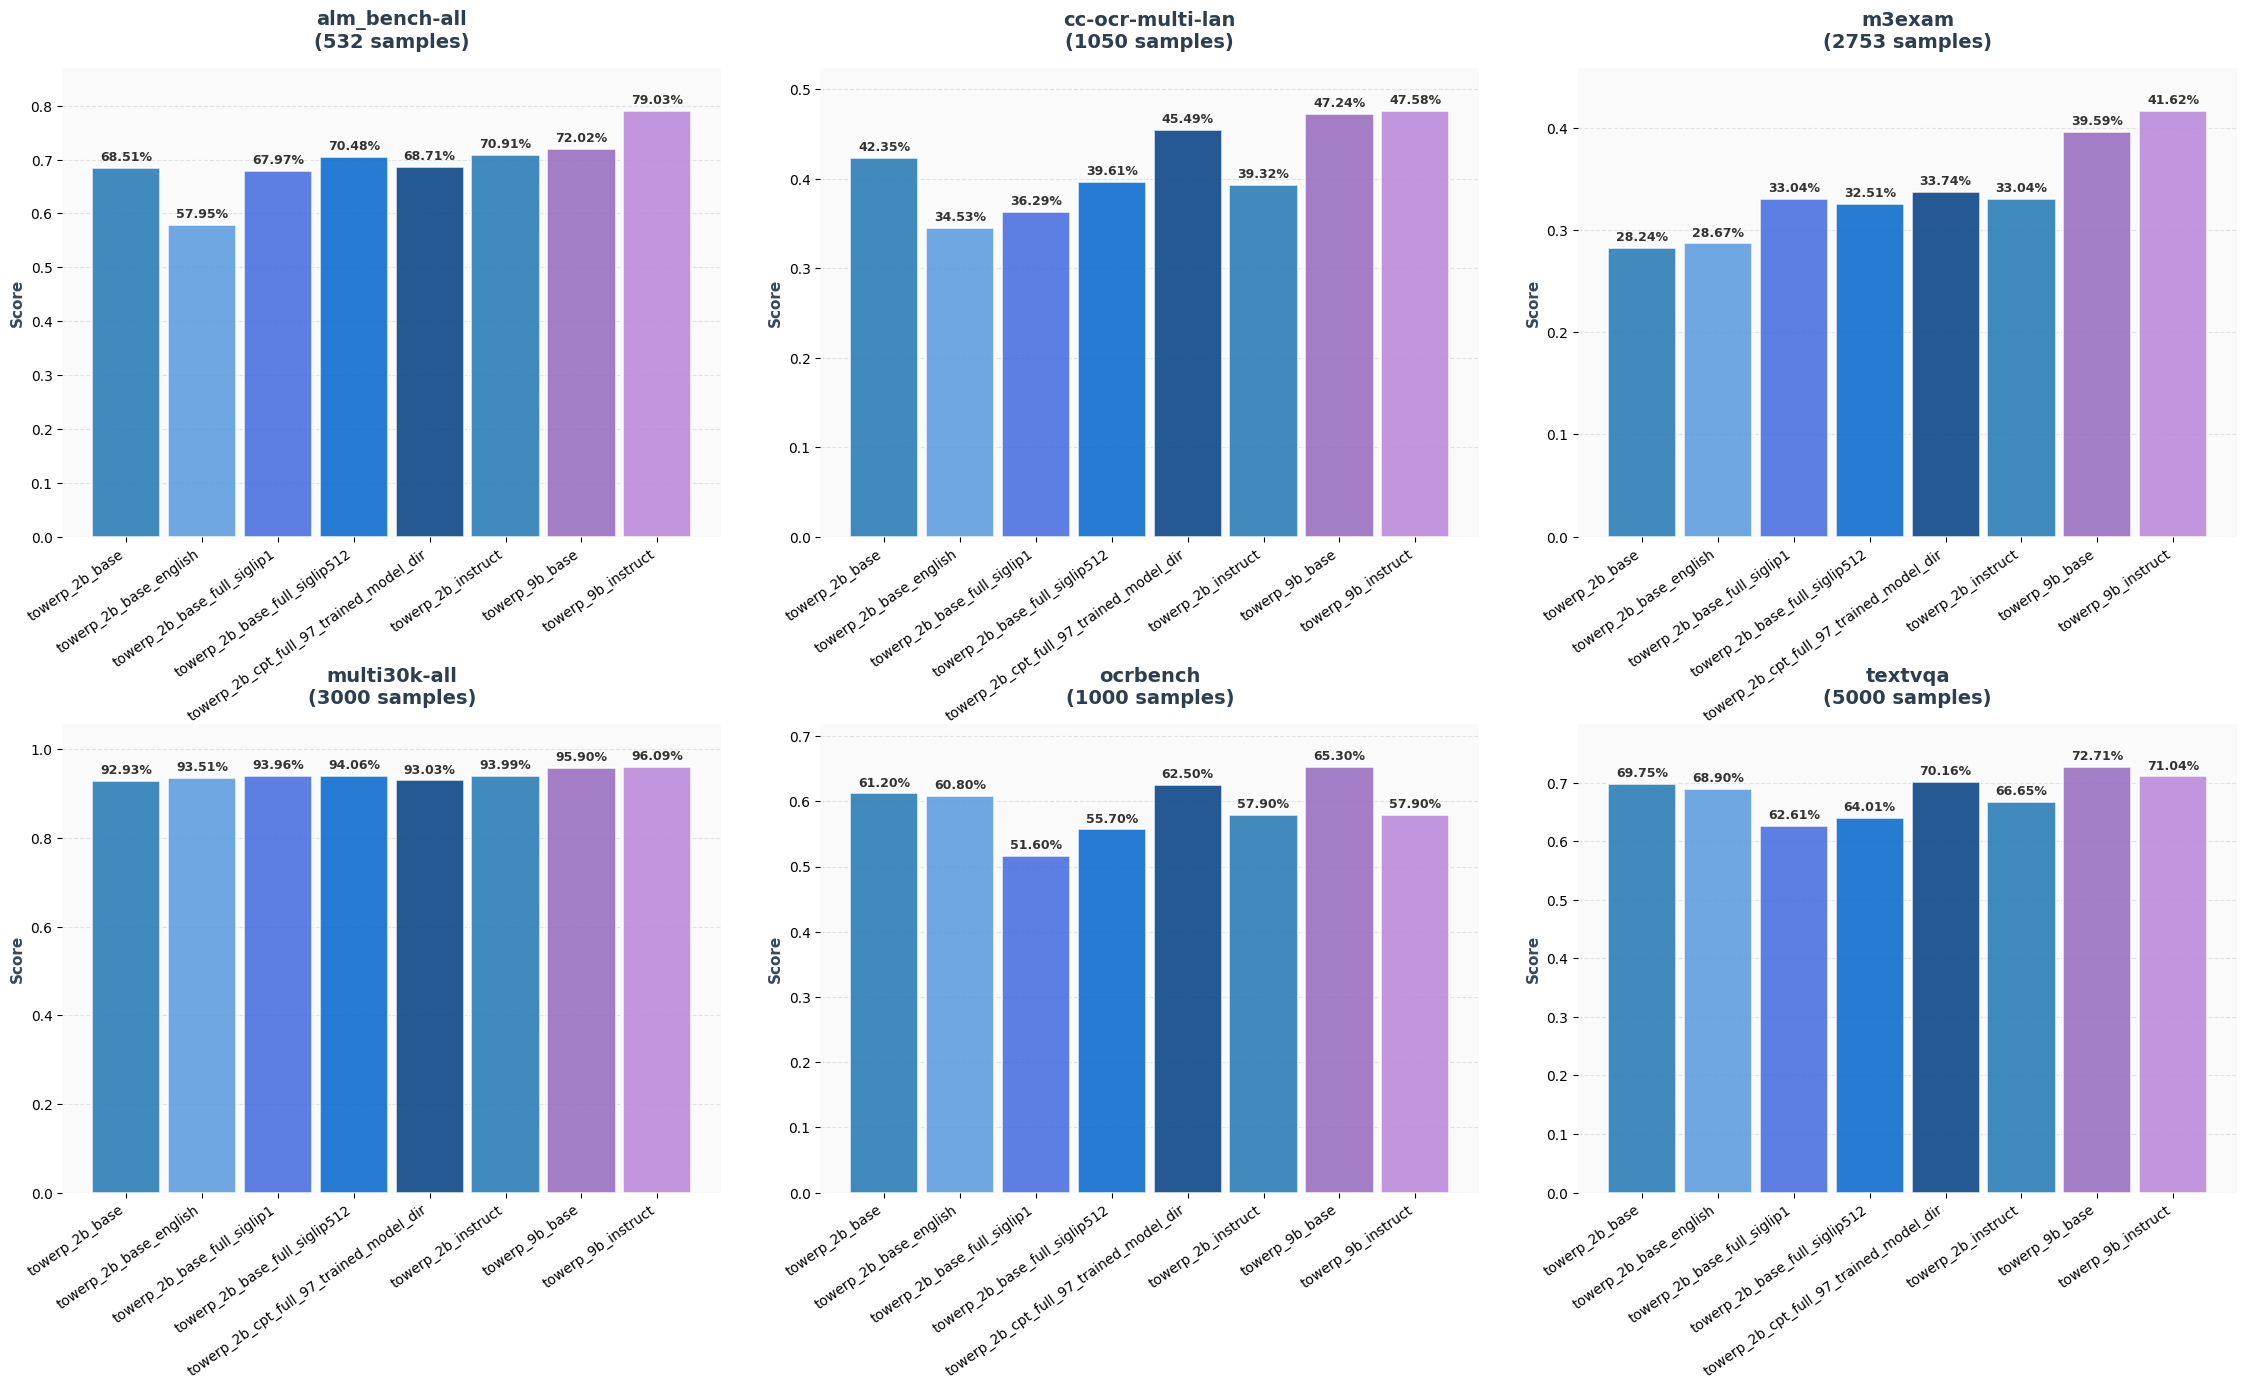

In [7]:
def plot_benchmarks_subplots(results: Dict, samples_per_bench: Dict) -> None:
    sorted_models = sorted(results.keys())
    sorted_benchmarks = sorted(results[sorted_models[0]].keys())
    nb_benchmarks = len(sorted_benchmarks)


    # 3x3 grid layout to accommodate 7 benchmarks
    fig, axes = plt.subplots(3, 3, figsize=(25, 20))
    # Remove spacing between subplots and add some padding
    fig.subplots_adjust(wspace=0.15, hspace=0.4, top=0.99, bottom=0.1, left=0.08, right=0.95)

    # Flatten axes array for easy iteration
    axes_flat = axes.flatten()

    # Define color schemes: blue variants for 2b models, purple variants for 9b models
    def get_model_colors(models):
        colors = []
        blue_variants = ['#1f77b4', '#5599dd', '#4169e1', '#0066cc', '#003d82']  # Different shades of blue
        purple_variants = ['#9467bd', '#b885db', '#8a2be2', '#9932cc', '#663399']  # Different shades of purple
        
        blue_idx = 0
        purple_idx = 0
        
        for model in models:
            if '2b' in model.lower():
                colors.append(blue_variants[blue_idx % len(blue_variants)])
                blue_idx += 1
            elif '9b' in model.lower():
                colors.append(purple_variants[purple_idx % len(purple_variants)])
                purple_idx += 1
            else:
                # Default color for models that don't match 2b or 9b pattern
                colors.append('#606060')  # Dark gray
        
        return colors

    model_colors = get_model_colors(sorted_models)

    for i, benchmark in enumerate(sorted_benchmarks):
        if i >= 9:  # Only handle up to 9 benchmarks for 3x3 grid
            break
            
        ax = axes_flat[i]
        x = np.arange(len(sorted_models))  # one bar per model
        values = [results[model][benchmark]['all'] for model in sorted_models]

        # Make bars closer together by increasing width and reducing spacing
        bars = ax.bar(x, values, width=0.9, color=model_colors, 
                     edgecolor='white', linewidth=1.2, alpha=0.85)

        # Annotate bars with percentage only (smaller, cleaner font)
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + max(values) * 0.01, 
                   f'{height*100:.2f}%', ha='center', va='bottom', fontsize=9, 
                   fontweight='bold', color='#333333')

        # Add benchmark name with sample count as title for each subplot
        sample_count = samples_per_bench.get(benchmark, 0)
        title_text = f"{benchmark}\n({sample_count} samples)"
        ax.set_title(title_text, fontsize=14, fontweight='bold', pad=15, 
                    color='#2c3e50')
        
        # Improve x-axis styling
        ax.set_xticks(x)
        ax.set_xticklabels(sorted_models, rotation=35, ha='right', fontsize=10)
        ax.set_ylabel("Score", fontsize=11, fontweight='bold', color='#34495e')
        
        # Add grid for better readability
        ax.grid(True, axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
        ax.set_axisbelow(True)
        
        # Set y-axis limits with some padding
        if values:
            y_max = max(values)
            ax.set_ylim(0, y_max * 1.1)

        # Remove outer frame (spines) and beautify
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        # Add subtle background color
        ax.set_facecolor('#fafafa')

        # Save individual benchmark plot with same styling
        fig_b, ax_b = plt.subplots(figsize=(8, 6))
        fig_b.patch.set_facecolor('white')
        
        bars_b = ax_b.bar(x, values, width=0.9, color=model_colors, 
                         edgecolor='white', linewidth=1.5, alpha=0.85)
        
        for bar in bars_b:
            height = bar.get_height()
            ax_b.text(bar.get_x() + bar.get_width()/2, height + max(values) * 0.01, 
                     f'{height*100:.2f}%', ha='center', va='bottom', fontsize=11, 
                     fontweight='bold', color='#333333')
        
        # Add benchmark name with sample count as title for individual plot
        sample_count = samples_per_bench.get(benchmark, 0)
        title_text = f"{benchmark}\n({sample_count} samples)"
        ax_b.set_title(title_text, fontsize=16, fontweight='bold', pad=20, color='#2c3e50')
        ax_b.set_xticks(x)
        ax_b.set_xticklabels(sorted_models, rotation=35, ha='right', fontsize=12)
        ax_b.set_ylabel("Score", fontsize=13, fontweight='bold', color='#34495e')
        ax_b.grid(True, axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
        ax_b.set_axisbelow(True)
        
        if values:
            ax_b.set_ylim(0, max(values) * 1.1)
        
        for spine in ax_b.spines.values():
            spine.set_visible(False)
        ax_b.set_facecolor('#fafafa')
        
        fig_b.tight_layout()
        #fig_b.savefig(f"summary_towervision_{benchmark}.png", dpi=300, bbox_inches='tight')
        plt.close(fig_b)

    # Hide any unused subplots
    for i in range(nb_benchmarks, 9):
        axes_flat[i].set_visible(False)
        axes_flat[i].set_facecolor('white')

    # show image
    plt.show()
    

plot_benchmarks_subplots(acc_summary, samples_per_bench)

In [8]:
from utils import (
    TOWER_VISION_LANGUAGES_TO_ADD,
    TOWER_VISION_LANGUAGES
)

In [63]:

def plot_metrics_per_bench(
    results: Dict, 
    samples_per_bench: Dict, 
    benchmarks: Optional[List[str]] = None, 
    models: Optional[List[str]] = None
) -> None:
    """
    Plots metrics for selected benchmarks and models. Only filtered benchmarks are plotted.
    Adds a "🚫" symbol to language labels that are not supported (not in TOWER_VISION_LANGUAGES).
    """

    # Get all models and benchmarks
    sorted_models = sorted(results.keys())
    sorted_benchmarks = sorted(results[sorted_models[0]].keys())

    print("Available benchmarks: ", sorted_benchmarks)
    if benchmarks is not None:
        assert set(benchmarks).issubset(set(sorted_benchmarks)), (
            "Benchmarks not found, available benchmarks: " + str(sorted_benchmarks)
        )
        sorted_benchmarks = [x for x in sorted_benchmarks if x in benchmarks]

    # Filter benchmarks without multilingual keys
    filtered_benchmarks = []
    for benchmark in sorted_benchmarks:
        keys = list(results[sorted_models[0]][benchmark].keys())
        print(keys)
        if keys == ["all"]:
            print("Removing benchmark: ", benchmark, " since it has only one key and 'all'")
        else:
            filtered_benchmarks.append(benchmark)
    sorted_benchmarks = filtered_benchmarks
    print("Filtered benchmarks: ", sorted_benchmarks)

    if models is not None:
        sorted_models = [name for name in sorted_models if name in models]
    print("Filtered models: ", sorted_models)

    # If no benchmarks left after filtering, exit early
    if not sorted_benchmarks:
        print("No benchmarks to plot after filtering.")
        return

    # Define color schemes: blue variants for 2b models, purple variants for 9b models
    def get_model_colors(models):
        colors = []
        blue_variants = ['#1f77b4', '#5599dd', '#4169e1', '#0066cc', '#003d82']
        purple_variants = ['#9467bd', '#b885db', '#8a2be2', '#9932cc', '#663399']
        blue_idx = 0
        purple_idx = 0
        for model in models:
            if '2b' in model.lower():
                colors.append(blue_variants[blue_idx % len(blue_variants)])
                blue_idx += 1
            elif '9b' in model.lower():
                colors.append(purple_variants[purple_idx % len(purple_variants)])
                purple_idx += 1
            else:
                colors.append('#606060')
        return colors

    model_colors = get_model_colors(sorted_models)

    # Only plot for filtered benchmarks
    for benchmark in sorted_benchmarks:
        # Collect all unique metrics for this benchmark, excluding "all"
        all_metrics = set()
        for model in sorted_models:
            metrics = results[model][benchmark].keys()
            filtered_metrics = {m for m in metrics if m != "all"}
            all_metrics.update(filtered_metrics)

        if not all_metrics:
            continue

        sample_count = samples_per_bench.get(benchmark, 0)

        # PLOT 1: English vs Multi (average of all other languages)
        plot_data = {}
        for model in sorted_models:
            if 'en' in results[model][benchmark]:
                en_score = results[model][benchmark]['en']
                other_scores = [
                    results[model][benchmark][metric]
                    for metric in all_metrics
                    if metric != 'en' and metric in results[model][benchmark]
                ]
                multi_score = sum(other_scores) / len(other_scores) if other_scores else 0
                plot_data[model] = {'en': en_score, 'multi': multi_score}

        if plot_data:
            x = np.arange(len(plot_data))
            en_values = [plot_data[model]['en'] for model in sorted_models if model in plot_data]
            multi_values = [plot_data[model]['multi'] for model in sorted_models if model in plot_data]
            model_names = [
                model.replace('TowerVision-Plus-', 'TV-').replace('towerp_', '').replace('towerp', '')
                for model in sorted_models if model in plot_data
            ]
            width = 0.35
            fig1, ax1 = plt.subplots(figsize=(8, 5))
            fig1.patch.set_facecolor('white')
            bars1 = ax1.bar(x - width/2, en_values, width, label='EN', color='#2E8B57', alpha=0.85)
            bars2 = ax1.bar(x + width/2, multi_values, width, label='Multi', color='#CD853F', alpha=0.85)
            for bar in bars1:
                height = bar.get_height()
                ax1.text(
                    bar.get_x() + bar.get_width()/2, 
                    height + max(en_values + multi_values) * 0.01,
                    f'{height*100:.1f}%', ha='center', va='bottom', fontsize=7, fontweight='bold'
                )
            for bar in bars2:
                height = bar.get_height()
                ax1.text(
                    bar.get_x() + bar.get_width()/2, 
                    height + max(en_values + multi_values) * 0.01,
                    f'{height*100:.1f}%', ha='center', va='bottom', fontsize=7, fontweight='bold'
                )
            ax1.set_title(
                f'{benchmark} - EN vs Multi ({sample_count} samples)',
                fontsize=12, fontweight='bold', pad=10, color='#2c3e50'
            )
            ax1.set_xticks(x)
            ax1.set_xticklabels(model_names, rotation=30, ha='right', fontsize=8)
            ax1.set_ylabel("Score", fontsize=9, fontweight='bold', color='#34495e')
            ax1.legend(fontsize=8, loc='upper right')
            ax1.grid(True, axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
            ax1.set_axisbelow(True)
            if en_values + multi_values:
                y_max = max(en_values + multi_values)
                ax1.set_ylim(0, y_max * 1.1)
            for spine in ax1.spines.values():
                spine.set_visible(False)
            ax1.set_facecolor('#fafafa')
            plt.tight_layout()
            fig1.savefig(
                f"summary_towervision_{benchmark}_en_vs_multi.png", 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none'
            )
            plt.close(fig1)

        # PLOT 2: All metrics with English first
        non_en_metrics = [m for m in sorted(all_metrics) if m != 'en']
        if 'en' in all_metrics:
            ordered_metrics = ['en'] + non_en_metrics
        else:
            ordered_metrics = non_en_metrics

        if ordered_metrics:
            fig2, ax2 = plt.subplots(figsize=(max(10, len(ordered_metrics) * 1.2), 5))
            fig2.patch.set_facecolor('white')
            metric_data = {}
            for metric in ordered_metrics:
                metric_values = []
                for model in sorted_models:
                    if metric in results[model][benchmark]:
                        metric_values.append(results[model][benchmark][metric])
                    else:
                        metric_values.append(0)
                metric_data[metric] = metric_values
            x = np.arange(len(ordered_metrics))
            width = 0.8 / len(sorted_models) if len(sorted_models) > 0 else 0.8
            for i, model in enumerate(sorted_models):
                values = [metric_data[metric][i] for metric in ordered_metrics]
                short_model = model.replace('TowerVision-Plus-', 'TV-').replace('towerp_', '').replace('towerp', '')
                bars = ax2.bar(
                    x + i * width - (len(sorted_models) - 1) * width / 2, 
                    values, width, label=short_model, color=model_colors[i], alpha=0.85
                )
                for j, bar in enumerate(bars):
                    height = bar.get_height()
                    if height > 0:
                        max_height = max([max(metric_data[m]) for m in ordered_metrics]) if ordered_metrics else 0
                        ax2.text(
                            bar.get_x() + bar.get_width()/2, 
                            height + max_height * 0.005,
                            f'{height*100:.0f}', ha='center', va='bottom', fontsize=6, fontweight='bold'
                        )
            x_labels = []
            for metric in ordered_metrics:
                label = metric.upper()
                # Add "+" if in TOWER_VISION_LANGUAGES_TO_ADD
                if metric in TOWER_VISION_LANGUAGES_TO_ADD:
                    label += "+"
                # Add 🚫 if not supported (not in TOWER_VISION_LANGUAGES)
                if metric not in TOWER_VISION_LANGUAGES:
                    label += " 🚫"
                x_labels.append(label)
            ax2.set_title(
                f'{benchmark} - All Languages ({sample_count} samples)',
                fontsize=11, fontweight='bold', pad=8, color='#2c3e50'
            )
            ax2.set_xticks(x)
            ax2.set_xticklabels(x_labels, rotation=0, ha='center', fontsize=8)
            ax2.set_ylabel("Score", fontsize=9, fontweight='bold', color='#34495e')
            ax2.legend(
                fontsize=7, ncol=len(sorted_models), 
                loc='upper center', bbox_to_anchor=(0.5, -0.05)
            )
            ax2.grid(True, axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
            ax2.set_axisbelow(True)
            if any(metric_data.values()):
                y_max = max([max(values) for values in metric_data.values()])
                ax2.set_ylim(0, y_max * 1.15)
            for spine in ax2.spines.values():
                spine.set_visible(False)
            ax2.set_facecolor('#fafafa')
            plt.tight_layout()
            plt.show()

Available benchmarks:  ['alm_bench-all', 'cc-ocr-multi-lan', 'm3exam', 'multi30k-all', 'ocrbench', 'textvqa']
['de', 'en', 'es', 'fr', 'it', 'ko', 'nl', 'pt', 'ru', 'all']
['de', 'es', 'fr', 'it', 'ko', 'pt', 'ru', 'all']
['af', 'zh', 'en', 'it', 'pt', 'thai', 'vi', 'all']
['cs', 'de', 'fr', 'all']
['all']
Removing benchmark:  ocrbench  since it has only one key and 'all'
['all']
Removing benchmark:  textvqa  since it has only one key and 'all'
Filtered benchmarks:  ['alm_bench-all', 'cc-ocr-multi-lan', 'm3exam', 'multi30k-all']
Filtered models:  ['towerp_2b_base_full_siglip1', 'towerp_2b_cpt_full_97_trained_model_dir']


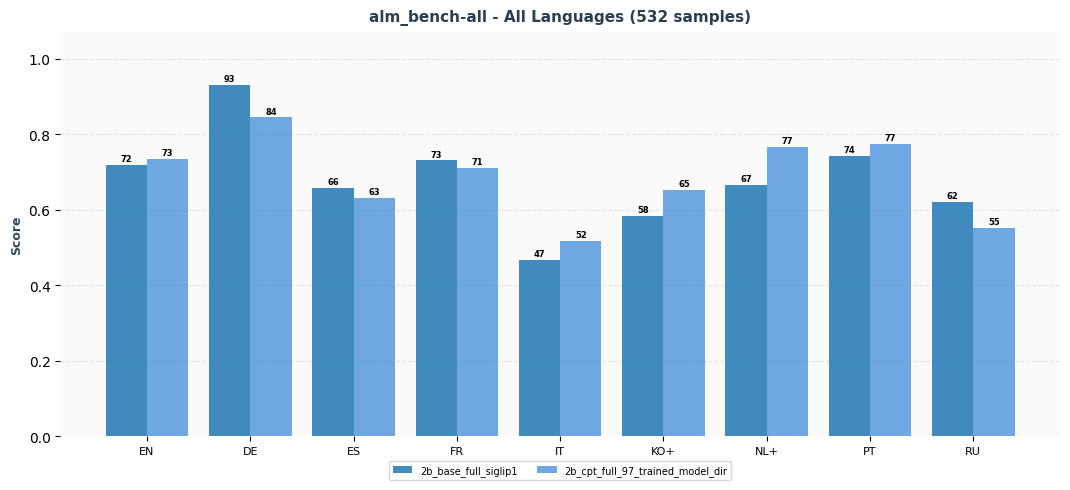

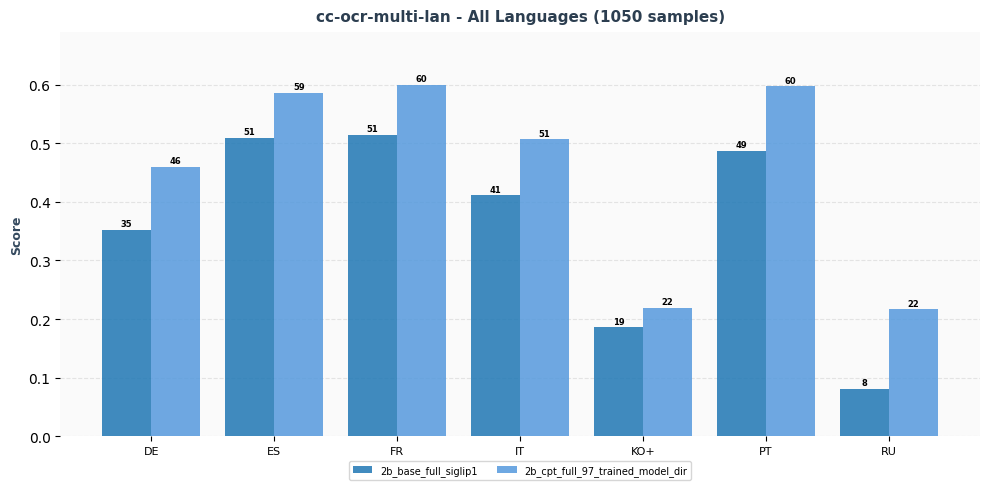

/tmp/ipykernel_825211/1203791560.py:207: UserWarning: Glyph 128683 (\N{NO ENTRY SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/home/gviveiros/.conda/envs/llava-next-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128683 (\N{NO ENTRY SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


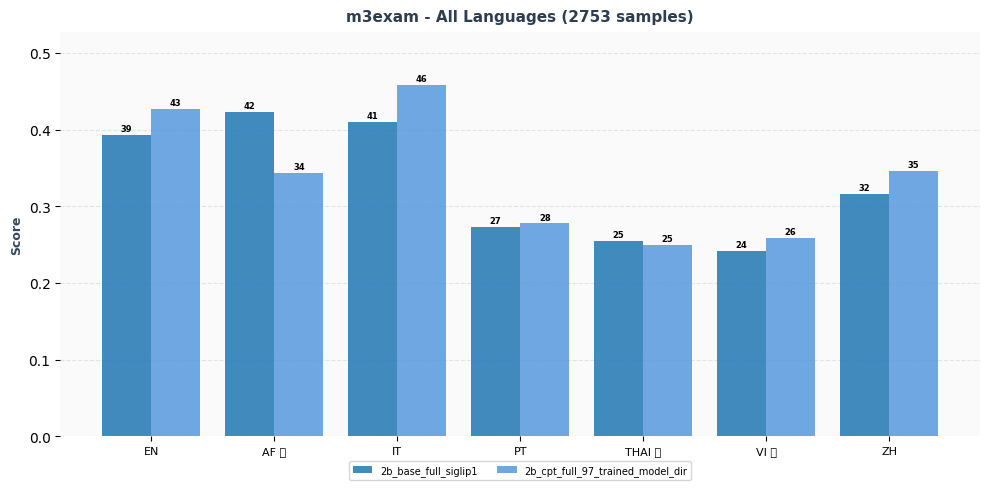

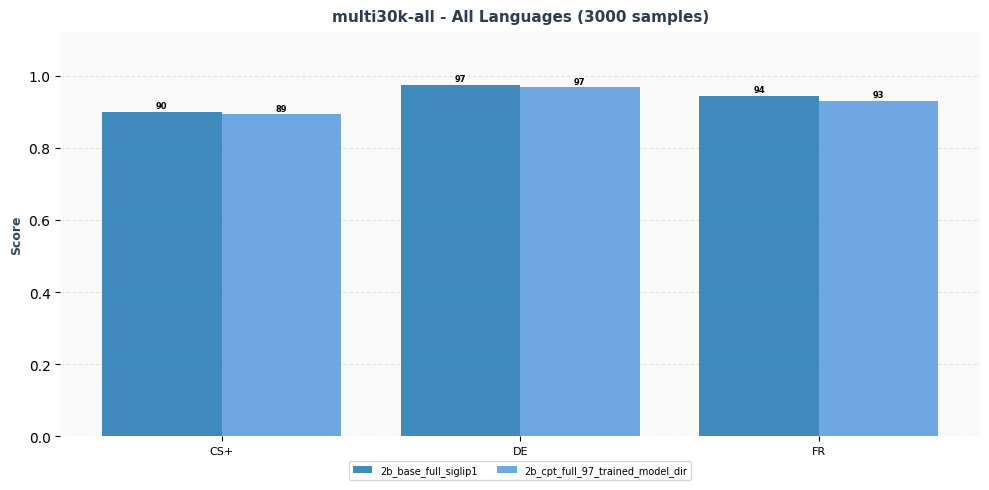

In [64]:
# all benchmarks together
#plot_metrics_per_bench(acc_summary, samples_per_bench, benchmarks=None, models=None)
plot_metrics_per_bench(acc_summary, samples_per_bench, benchmarks=None, models=["towerp_2b_base_full_siglip1", "towerp_2b_cpt_full_97_trained_model_dir"])

In [40]:

def plot_all_metrics_subplots(results: Dict, samples_per_language: Dict) -> None:
    sorted_models = sorted(results.keys())
    sorted_benchmarks = sorted(results[sorted_models[0]].keys())
    
    # Collect all unique metrics across all benchmarks, excluding "all"
    all_metrics = set()
    for model in sorted_models:
        for benchmark in sorted_benchmarks:
            metrics = results[model][benchmark].keys()
            # Filter out "all" metric
            filtered_metrics = {m for m in metrics if m != "all"}
            all_metrics.update(filtered_metrics)
    
    sorted_metrics = sorted(all_metrics)
    nb_metrics = len(sorted_metrics)
    
    # Calculate grid size - try to make it roughly square
    import math
    cols = math.ceil(math.sqrt(nb_metrics))
    rows = math.ceil(nb_metrics / cols)
    
    # Create subplots with appropriate size
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    fig.subplots_adjust(wspace=0.15, hspace=0.4, top=0.99, bottom=0.1, left=0.08, right=0.95)
    
    # Flatten axes array for easy iteration
    if rows == 1 and cols == 1:
        axes_flat = [axes]
    elif rows == 1 or cols == 1:
        axes_flat = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    else:
        axes_flat = axes.flatten()
    
    # Define color schemes: blue variants for 2b models, purple variants for 9b models
    def get_model_colors(models):
        colors = []
        blue_variants = ['#1f77b4', '#5599dd', '#4169e1', '#0066cc', '#003d82']
        purple_variants = ['#9467bd', '#b885db', '#8a2be2', '#9932cc', '#663399']
        
        blue_idx = 0
        purple_idx = 0
        
        for model in models:
            if '2b' in model.lower():
                colors.append(blue_variants[blue_idx % len(blue_variants)])
                blue_idx += 1
            elif '9b' in model.lower():
                colors.append(purple_variants[purple_idx % len(purple_variants)])
                purple_idx += 1
            else:
                colors.append('#606060')
        
        return colors

    model_colors = get_model_colors(sorted_models)

    for i, metric in enumerate(sorted_metrics):
        if i >= len(axes_flat):
            break
            
        ax = axes_flat[i]
        
        # Aggregate values for this metric across benchmarks by language/model
        aggregated_data = {}
        
        for model in sorted_models:
            values_for_model = []
            for benchmark in sorted_benchmarks:
                if metric in results[model][benchmark]:
                    values_for_model.append(results[model][benchmark][metric])
            
            # Calculate average across benchmarks for this model and metric
            if values_for_model:
                aggregated_data[model] = sum(values_for_model) / len(values_for_model)
        
        if not aggregated_data:
            ax.set_visible(False)
            continue
            
        x = np.arange(len(aggregated_data))
        values = list(aggregated_data.values())
        x_labels = list(aggregated_data.keys())  # Just model names, no benchmark names
        
        # Create colors for each bar using the same gradient system as the first function
        bar_colors = []
        for model_name in x_labels:
            # Find the index of this model in sorted_models to get consistent color
            model_index = sorted_models.index(model_name)
            bar_colors.append(model_colors[model_index])
        
        bars = ax.bar(x, values, width=0.9, color=bar_colors, 
                     edgecolor='white', linewidth=1.2, alpha=0.85)

        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2, height + max(values) * 0.01, 
                       f'{height*100:.2f}%', ha='center', va='bottom', fontsize=7, 
                       fontweight='bold', color='#333333')

        # Check if metric is a language in TOWER_VISION_LANGUAGES_TO_ADD and add tag
        title_text = metric
        if metric in TOWER_VISION_LANGUAGES:
            title_text = f"{metric} (supp)"
        else:
            title_text = f"{metric} (not supp)"
        
        if metric in TOWER_VISION_LANGUAGES_TO_ADD:
            title_text += " | +"
        
        # Add sample count to the title
        sample_count = samples_per_language.get(metric, 0)
        title_text += f"\n({sample_count} samples)"
        
        ax.set_title(title_text, fontsize=10, fontweight='bold', pad=12, color='#2c3e50')
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=7)
        ax.set_ylabel("Score", fontsize=8, fontweight='bold', color='#34495e')
        ax.grid(True, axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
        ax.set_axisbelow(True)
        
        if values:
            y_max = max(values)
            ax.set_ylim(0, y_max * 1.1)

        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.set_facecolor('#fafafa')

    # Hide any unused subplots
    for i in range(nb_metrics, len(axes_flat)):
        axes_flat[i].set_visible(False)

    plt.show()


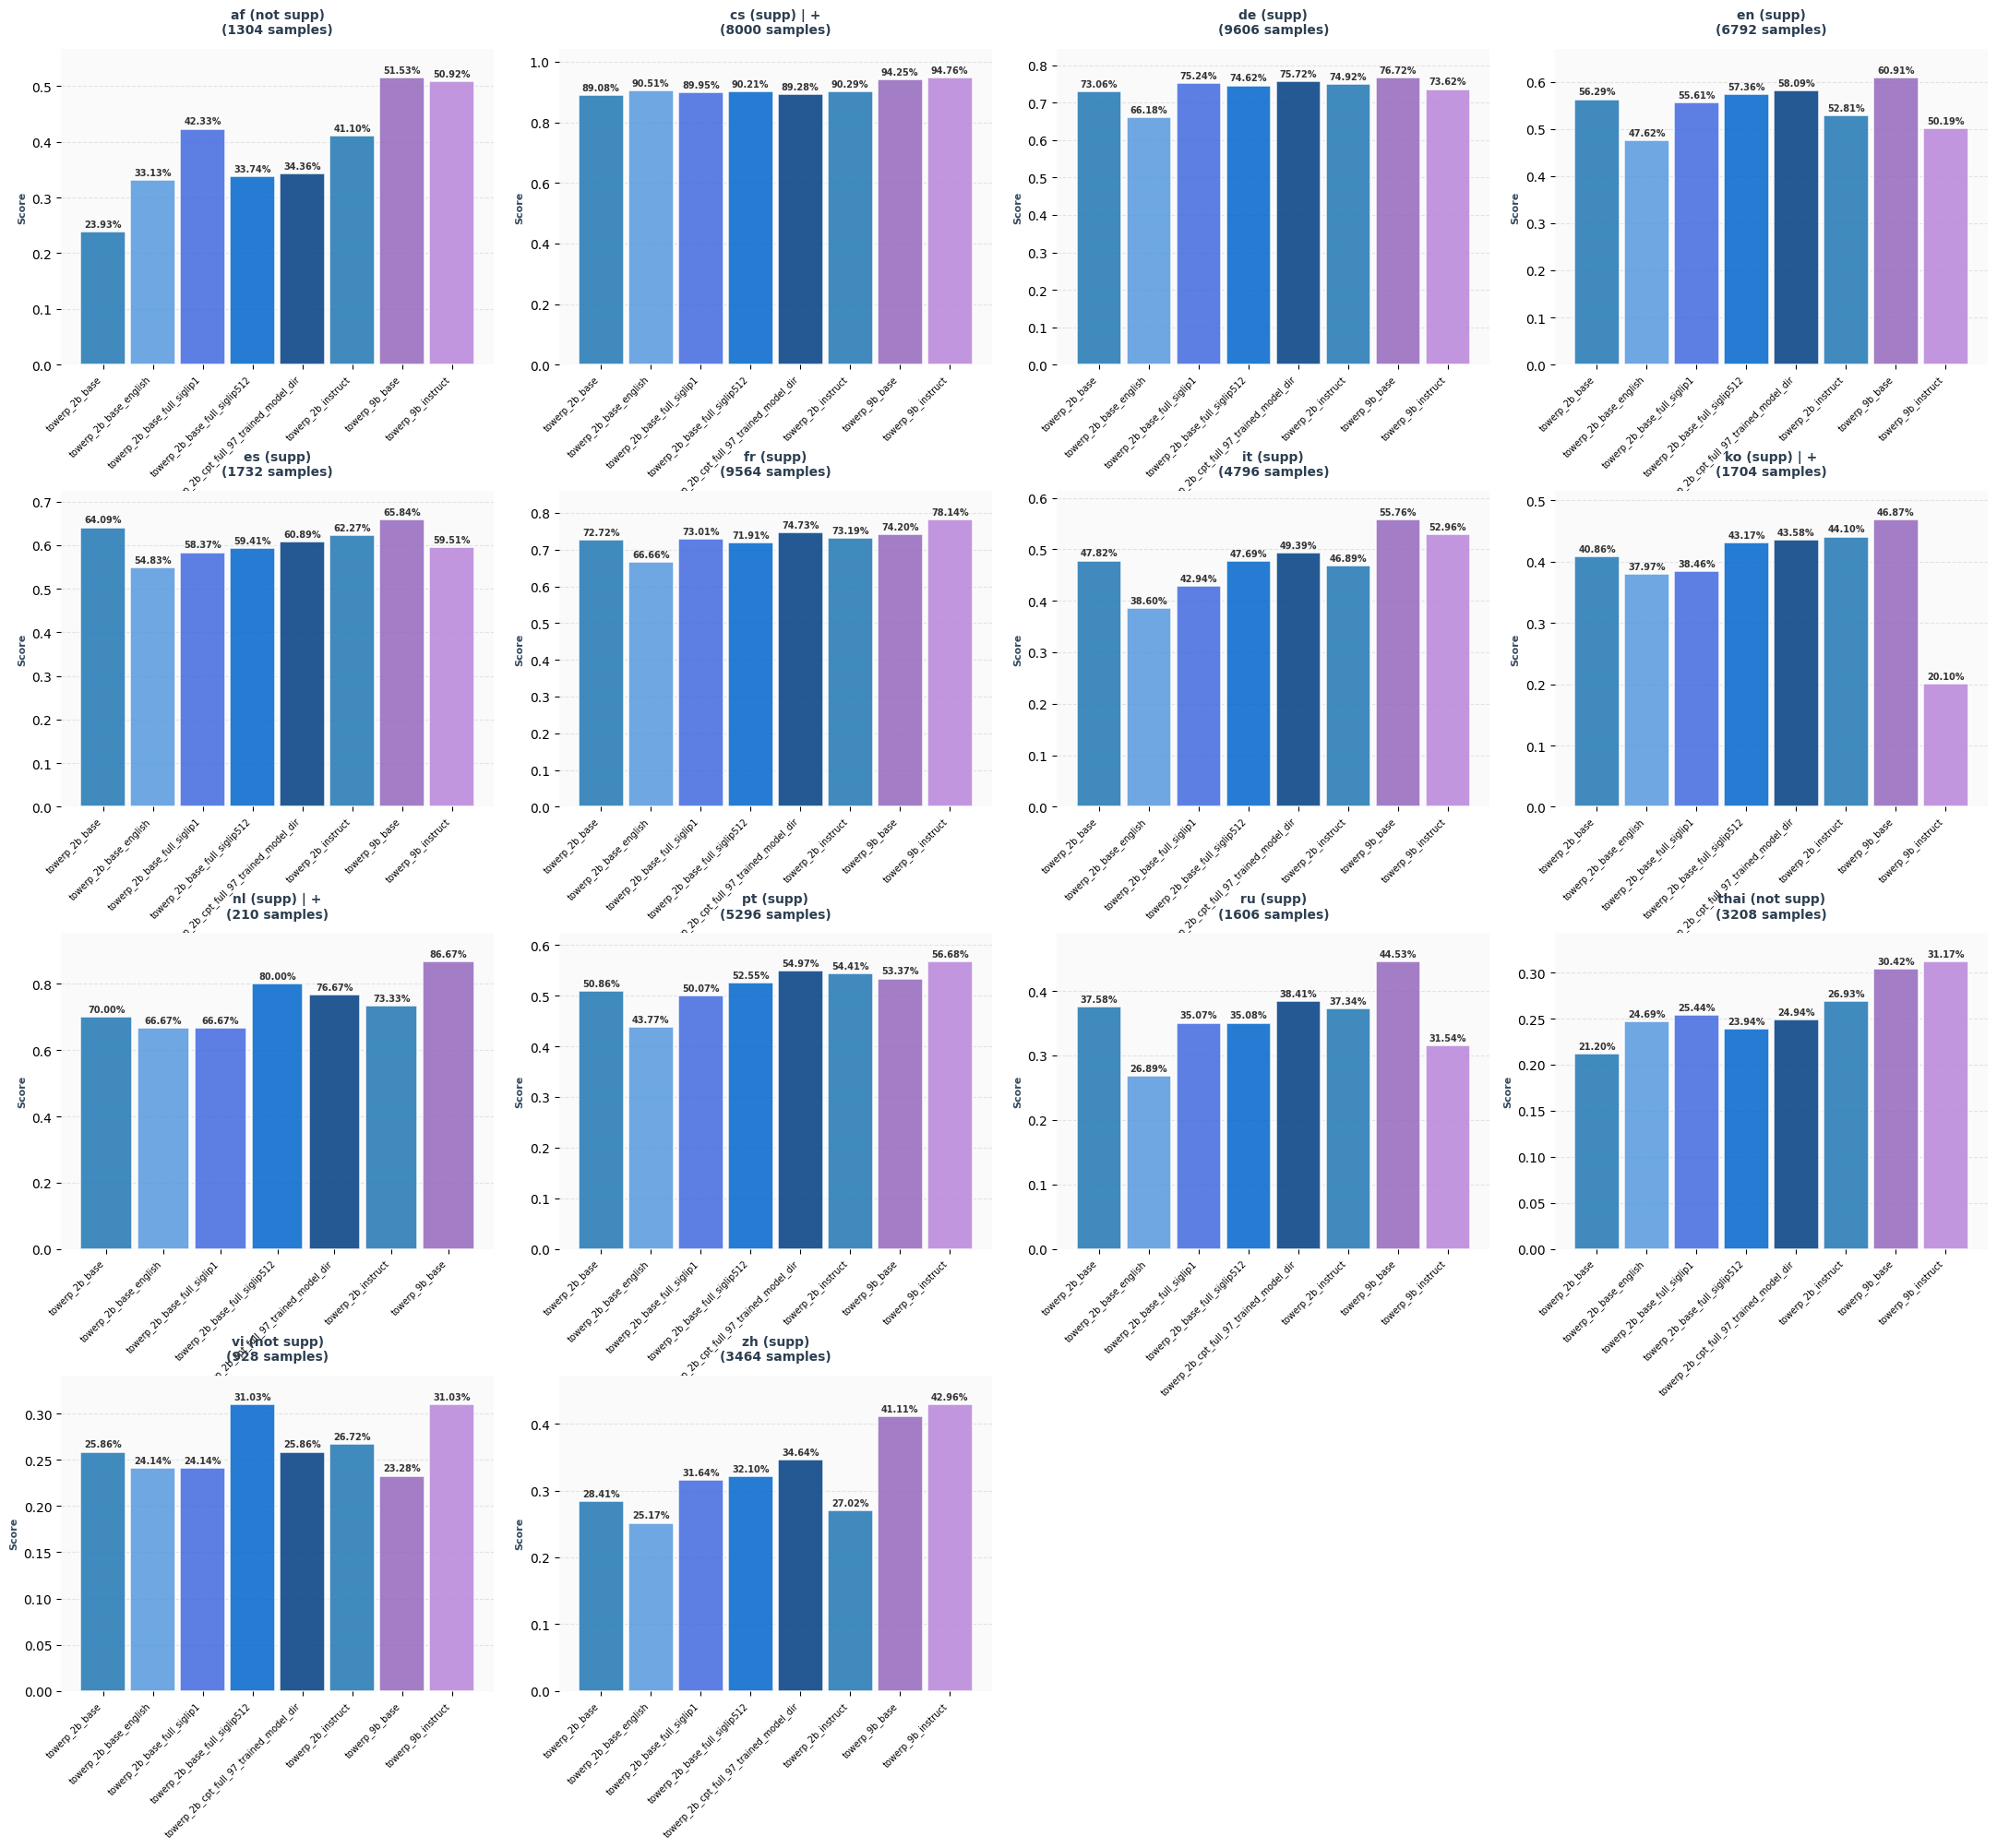

In [11]:
plot_all_metrics_subplots(acc_summary, samples_per_language)